In [1]:
import tensorflow as tf
import numpy as np

import innvestigate
import innvestigate.utils as iutils
from innvestigate.utils.visualizations import heatmap

from keras.models import Model
from keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Activation, Cropping2D, Lambda, Flatten
from keras.layers.normalization import BatchNormalization

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plot
import numpy as np
import os
%matplotlib inline  

/Users/gchlebus/anaconda2/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
def ConvBNRelu(input_tensor, filters, batch_norm=True):
    out = Conv2D(filters, (3, 3), activation=None, padding='valid', use_bias=False)(input_tensor)
    if batch_norm:
        out = BatchNormalization(axis=-1)(out)
    return Activation('relu')(out)


def get_model(weights=None, flatten_output=False, last_activation="sigmoid", batch_norm=True):
    filters = 4
    inputs = Input((28, 28, 1), name="input")

    conv1 = ConvBNRelu(inputs, filters, batch_norm=batch_norm)
    conv2 = ConvBNRelu(conv1, filters, batch_norm=batch_norm)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = ConvBNRelu(pool1, 2*filters, batch_norm=batch_norm)
    conv4 = ConvBNRelu(conv3, 2*filters, batch_norm=batch_norm)

    up1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), activation='relu', padding='valid')(conv4)
    up1 = concatenate([up1, Cropping2D(cropping=(4, 4))(conv2)])
    
    conv5 = ConvBNRelu(up1, filters, batch_norm=batch_norm)
    conv6 = ConvBNRelu(conv5, filters, batch_norm=batch_norm)

    logits = Conv2D(1, (1, 1), activation=last_activation)(conv6)
    
    if flatten_output:
        logits = Flatten()(logits)

    model = Model(inputs=[inputs], outputs=[logits])
    model.compile(loss="binary_crossentropy", optimizer="adam")
    if weights is not None:
        model.load_weights(weights)
    return model

In [4]:
model = get_model(batch_norm=False)


batch_size = 32

x = mnist.train.images
count = len(x)
x = np.reshape(x, (count, 28, 28, 1))
y = np.where(x > 0.5, 1, 0)
y = y[:, 8:-8, 8:-8, :]
model.fit(x, y, batch_size=batch_size, epochs=2)
model.save_weights("params_wo_batchnorm")

Epoch 1/2
55000/55000 [==============================] - 25s 446us/step - loss: 0.0843
Epoch 2/2
55000/55000 [==============================] - 24s 432us/step - loss: 0.0240


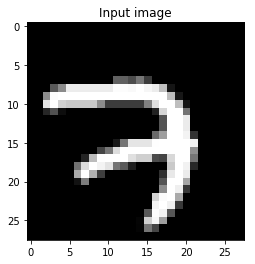

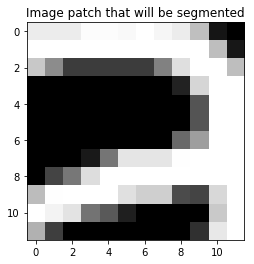

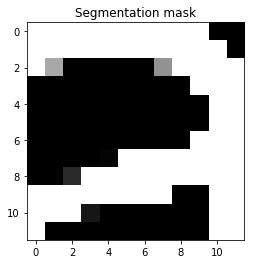

In [9]:
model = get_model("params_wo_batchnorm", batch_norm=False)
sample = x[0:1]
plot.imshow(sample.squeeze(), cmap="gray")
plot.gca().set_title("Input image")
plot.show()

plot.imshow(sample[:, 8:-8, 8:-8].squeeze(), cmap="gray")
plot.gca().set_title("Image patch that will be segmented")
plot.show()

p = model.predict(sample)
p = p.squeeze()
#p = np.pad(p, (8, 8), mode="constant", constant_values=0)
i, j = np.unravel_index(np.argmax(p), p.shape)
plot.imshow(p.squeeze(), cmap="gray")
plot.gca().set_title("Segmentation mask")
plot.show()

Neuron output at (10, 11) =  14.302249
Flattened model neuron output at (10, 11) =  14.302249
--------------------------------------------------------------------------------
Run analysis multiple times for the same output neuron index
ITERATION 0
relevance at index =  4.29285
analysis.sum() =  13.667119


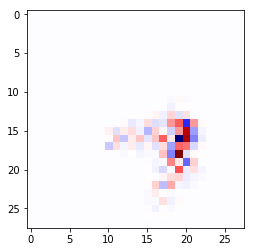

ITERATION 1
relevance at index =  3.6035206
analysis.sum() =  13.667117


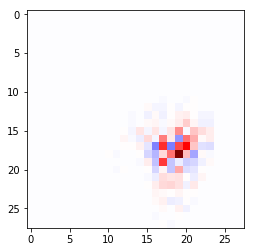

ITERATION 2
relevance at index =  -59.403824
analysis.sum() =  13.667109


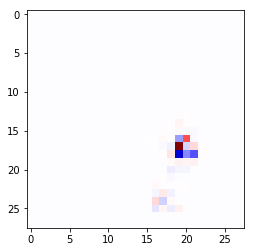

In [14]:
pixel_x = 11
pixel_y = 10
model = get_model("params_wo_batchnorm", last_activation="linear", batch_norm=False)
p = model.predict(sample)
print('Neuron output at (%d, %d) = ' % (pixel_y, pixel_x), p[0, pixel_y, pixel_x, 0])
index = np.ravel_multi_index((0, pixel_y, pixel_x, 0), p.shape)
flatten_model = get_model("params_wo_batchnorm", flatten_output=True, last_activation="linear", batch_norm=False)
flat_p = flatten_model.predict(sample)
print('Flattened model neuron output at (%d, %d) = ' % (pixel_y, pixel_x), flat_p[0, index])


print("-" * 80)
print("Run analysis multiple times for the same output neuron index")
for i in range(3):
    print("ITERATION %d" % i)
    analyzer = innvestigate.analyzer.LRPEpsilon(flatten_model, input_layer_rule=(0, 1), neuron_selection_mode="index")
    analysis = analyzer.analyze(sample, index)
    print("relevance at index = ", analysis[0, pixel_y+8, pixel_x+8, 0])
    print("analysis.sum() = ", analysis.sum())
    analysis = heatmap(analysis)
    plot.imshow(analysis.squeeze(), cmap='gray', interpolation='nearest')
    plot.show()